# Cartopy testing


## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [2]:
%matplotlib inline


In [3]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
# from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy
from matplotlib import colors as c
from matplotlib import ticker
from mpl_toolkits import mplot3d

# from xhistogram.xarray import histogram

In [4]:

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [5]:
# paramters

global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"
restrict_years = "20??"  # restricts to 2014 to 2018
# restrict_years = "2014"  # restricts to 2014

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [6]:
mesh_mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")

found 1 mesh mask files


In [7]:
mesh_mask = xr.open_dataset(mesh_mask_files[0]
)



## Define a section along an isobath and find grid points along the section

### trying to build a section along the 1000 m contour and linked across 47 N. This also goes round a bit of Flemish Cap

In [16]:
# range of stations from west to east, stations 0-12. Python indexing.

def plotDepthContoursGrid(ax):
    
    cs = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax,
         colors = 'grey', levels = [1000],zorder=1,
    );

    cs1 = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax,
         colors = 'k', levels = [0.5],zorder=1
    );
    ax.clabel(cs, inline=1,inline_spacing=10,fontsize=8,manual=[(1200,400)])
    
# need to locate the right contour (use trial and error). each separate contour has separate index
# in this example identified as contour 0
#     for i in [0,71]:
    for i in [0,79]:
        v = cs.collections[0].get_paths()[i].vertices
        x = v[:,0]
        y = v[:,1]

        ax.plot(x,y,color='r')
    return cs

In [9]:
depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z").compute()
# 9-cell min
# depth = depth.rolling(x=3,center=True).min()
# depth = depth.rolling(y=3,center=True).min()
# 5-cell + shape min
depth1 = depth.rolling(x=3,center=True).min()
depth2 = depth1.rolling(y=3,center=True).min()


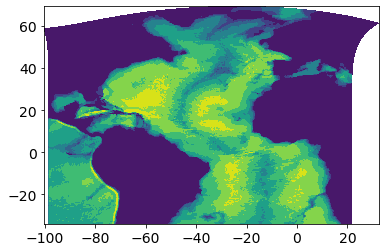

In [10]:
plt.contourf(mesh_mask.nav_lon,mesh_mask.nav_lat,depth2)

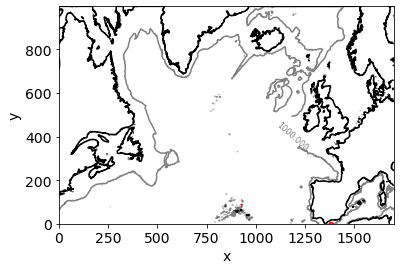

In [17]:
fig,ax = plt.subplots()
cs = plotDepthContoursGrid(ax)


## Plot section

In [ ]:
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(figsize=(12,8),subplot_kw={'projection': cartopy.crs.PlateCarree()})
extent = [-70, 0, 44, 66]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m',zorder=10)
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='black')

cs = ax.contour(mesh_mask.nav_lon,mesh_mask.nav_lat,depth2,levels=[1000],colors='w')

# need to locate the right contour (use trial and error). each separate contour has separate index
# in this example identified as contour 0
#     for i in [0,71]:
for i in range(len(cs.collections[0].get_paths())):
    v = cs.collections[0].get_paths()[i].vertices
    x = v[:,0]
    y = v[:,1]-3

    ax.plot(x,y,color='lightblue',zorder=10)
for i in [1,434]:
    v = cs.collections[0].get_paths()[i].vertices
    x = v[:,0]
    y = v[:,1]

    ax.plot(x,y,color='b',zorder=10)


plt.savefig('test.pdf')
plt.savefig('test.eps')

In [14]:
cs.collections[0].get_paths()[0].vertices

array([[-98.34999847, -33.95419716],
       [-98.30000305, -33.95422957],
       [-98.25      , -33.9542297 ],
       ...,
       [-98.38610695, -33.88274002],
       [-98.38611334, -33.92424011],
       [-98.34999847, -33.95419716]])

In [15]:
mesh_mask.nav_lon.data

array([[ -98.45    ,  -98.4     ,  -98.35    , ...,   21.6     ,
          21.65    ,   21.7     ],
       [ -98.45    ,  -98.4     ,  -98.35    , ...,   21.6     ,
          21.65    ,   21.7     ],
       [ -98.45    ,  -98.4     ,  -98.35    , ...,   21.6     ,
          21.65    ,   21.7     ],
       ...,
       [-100.45174 , -100.413414, -100.3751  , ...,   32.1668  ,
          32.21202 ,   32.25721 ],
       [-100.456696, -100.41841 , -100.38012 , ...,   32.19387 ,
          32.239075,   32.28425 ],
       [-100.46167 , -100.42341 , -100.38515 , ...,   32.22099 ,
          32.26618 ,   32.311337]], dtype=float32)

<IPython.core.display.Javascript object>


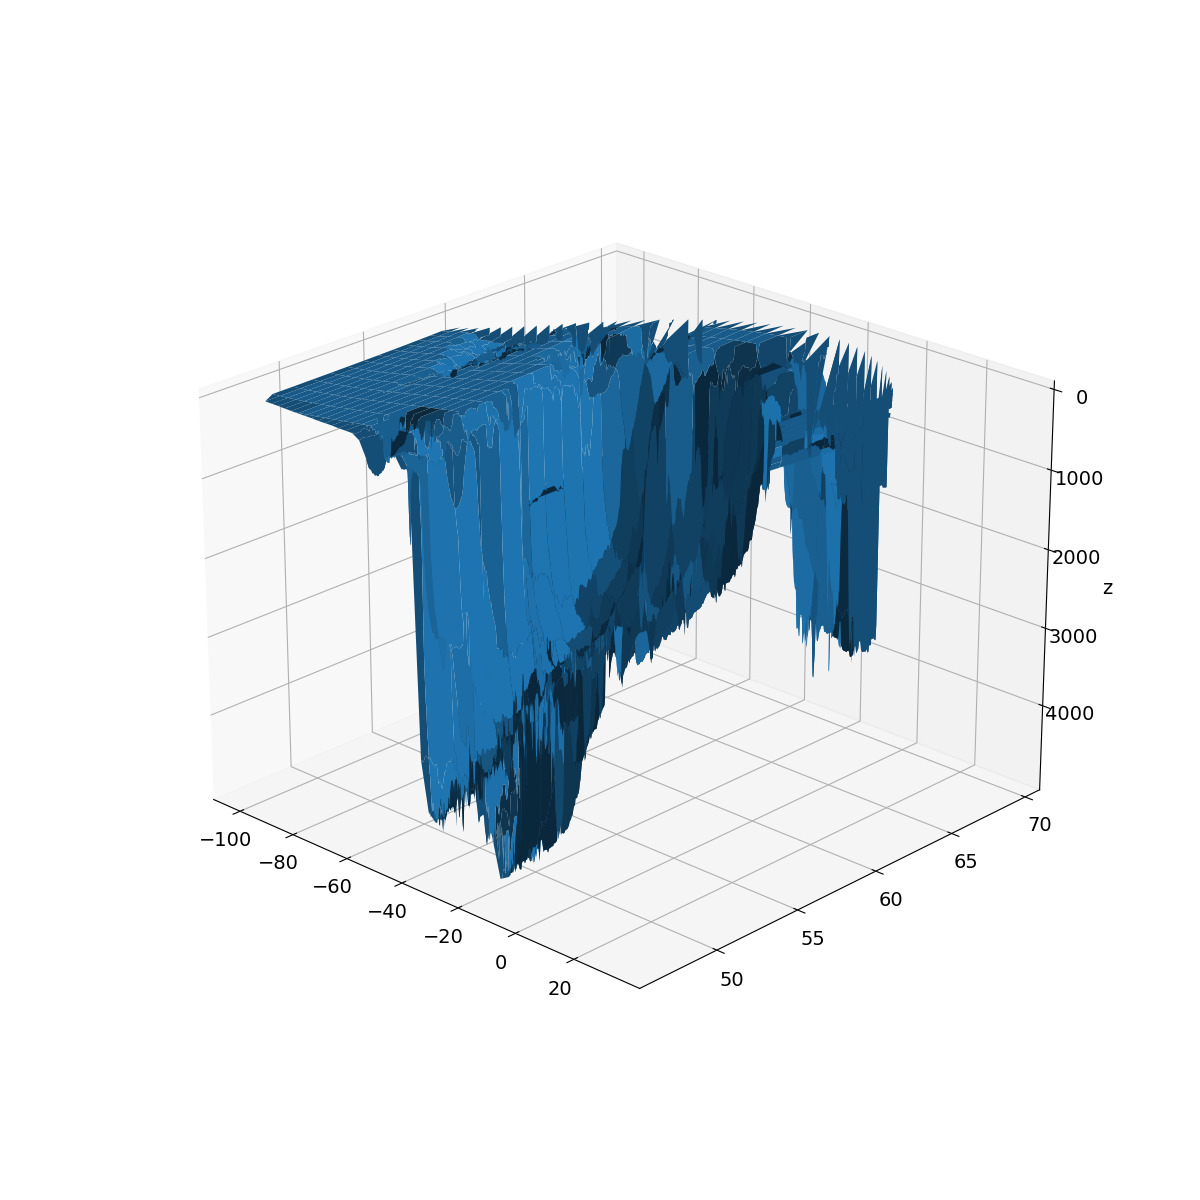

In [16]:
from matplotlib import cm
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

x=mesh_mask.nav_lon.where(mesh_mask.nav_lat > 47)
y=mesh_mask.nav_lat.where(mesh_mask.nav_lat > 47)
z=depth2.where(mesh_mask.nav_lat > 47)

surf = ax.plot_surface(x,y,z)
ax.invert_zaxis()
ax.set_zlabel('z')
ax.set_zlabel('z')
plt.show()

<IPython.core.display.Javascript object>


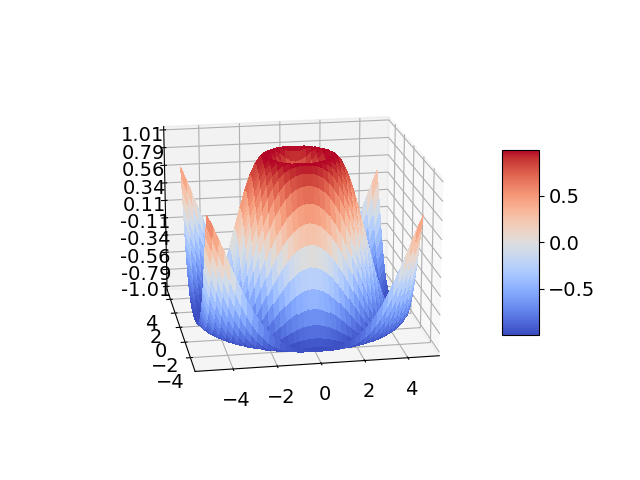

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [1]:
conda list

# packages in environment at /opt/tljh/user/envs/py3_traj_clustering_2021.09.19.1:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
bleach                    4.1.0              pyhd8ed1ab_0    conda-forge
bokeh                     2.3.3            py39h06a4308_0  
boost-cpp                 1.74.0               h312852a_4    conda-forge
brotlipy                  0.7.0           py39h3811e60_1001    conda-forge
bzip2                     1.0.8                h7f98